# Theta phase and power

## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)
- To run this notebook, you should have already completed the 
  [LFP](./12_LFP.ipynb) notebook and populated the `LFPBand` table. 
  
In this tutorial, we demonstrate how to generate analytic signals from the LFP
data, as well as how to compute theta phases and power.

## Imports


In [4]:
import os
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.lfp.analysis.v1.lfp_band as lfp_band

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

## Acquire Signal

First, we'll acquire the theta band analytic signal from the `LFPBand` data for
electrodes of interest. We can grab keys from this table.

In [5]:
lfp_band.LFPBandV1()

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,Theta 5-11 Hz,1000,minirec20230622_.nwb,01_s1_first9,100,minirec20230622_H89T89A0CK.nwb,01_s1_first9 lfp band 100Hz,71bbb1a8-409e-48eb-a336-8c70fd5d6b74


Now, we create a keys to reference the theta band data.

In [6]:
nwb_file_name = "minirec20230622_.nwb"
lfp_key = dict(
    nwb_file_name=nwb_file_name,
    filter_name="Theta 5-11 Hz",
)
lfp_band.LFPBandV1() & lfp_key

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
1e7fbe35-034b-ed8e-7965-a0467ae5c0a4,Theta 5-11 Hz,1000,minirec20230622_.nwb,01_s1_first9,100,minirec20230622_H89T89A0CK.nwb,01_s1_first9 lfp band 100Hz,71bbb1a8-409e-48eb-a336-8c70fd5d6b74


We do not need all electrodes for theta phase/power, so we define a list for
analyses. When working with full data, this list might limit to hippocampal
reference electrodes. 

Make sure that the chosen electrodes already exist in the LFPBand data; if not,
go to the LFP tutorial to generate them.

In [7]:
electrode_list = [0]

all_electrodes = (  # All available electrode ids
    (lfp_band.LFPBandV1() & lfp_key).fetch_nwb()[0]["lfp_band"]
).electrodes.data[:]

np.isin(electrode_list, all_electrodes)  # Check if our list is in 'all'

array([ True])

Next, we'll compute the theta analytic signal.

In [9]:
theta_analytic_signal = (
    lfp_band.LFPBandV1() & lfp_key
).compute_analytic_signal(electrode_list=electrode_list)

theta_analytic_signal

,electrode 0
time,
1.687475e+09,-124.000000-133.973800j
1.687475e+09,-30.000000-308.834746j
1.687475e+09,56.000000-267.135234j
1.687475e+09,139.000000-293.141114j
1.687475e+09,227.000000-236.059129j
...,...
1.687475e+09,-548.000000+29.032951j
1.687475e+09,-464.000000-225.303955j
1.687475e+09,-291.000000-329.028626j


In the dataframe above, the index is the timestamps, and the columns are the
analytic signals of theta band (complex numbers) for each electrode.

## Compute phase and power



Using a similar method, we can compute theta phase and power from the LFPBand
table.

In [10]:
theta_phase = (lfp_band.LFPBandV1() & lfp_key).compute_signal_phase(
    electrode_list=electrode_list
)
theta_power = (lfp_band.LFPBandV1() & lfp_key).compute_signal_power(
    electrode_list=electrode_list
)

We can get the theta band data to plot with the theta phase results.


In [11]:
theta_band = (lfp_band.LFPBandV1() & lfp_key).fetch_nwb()[0]["lfp_band"]
electrode_index = np.isin(theta_band.electrodes.data[:], electrode_list)
theta_band_selected = theta_band.data[:, electrode_index]

## Plot results

We can overlay theta and detected phase for each electrode.

_Note:_ The red horizontal line indicates phase 0, corresponding to the through
of theta.

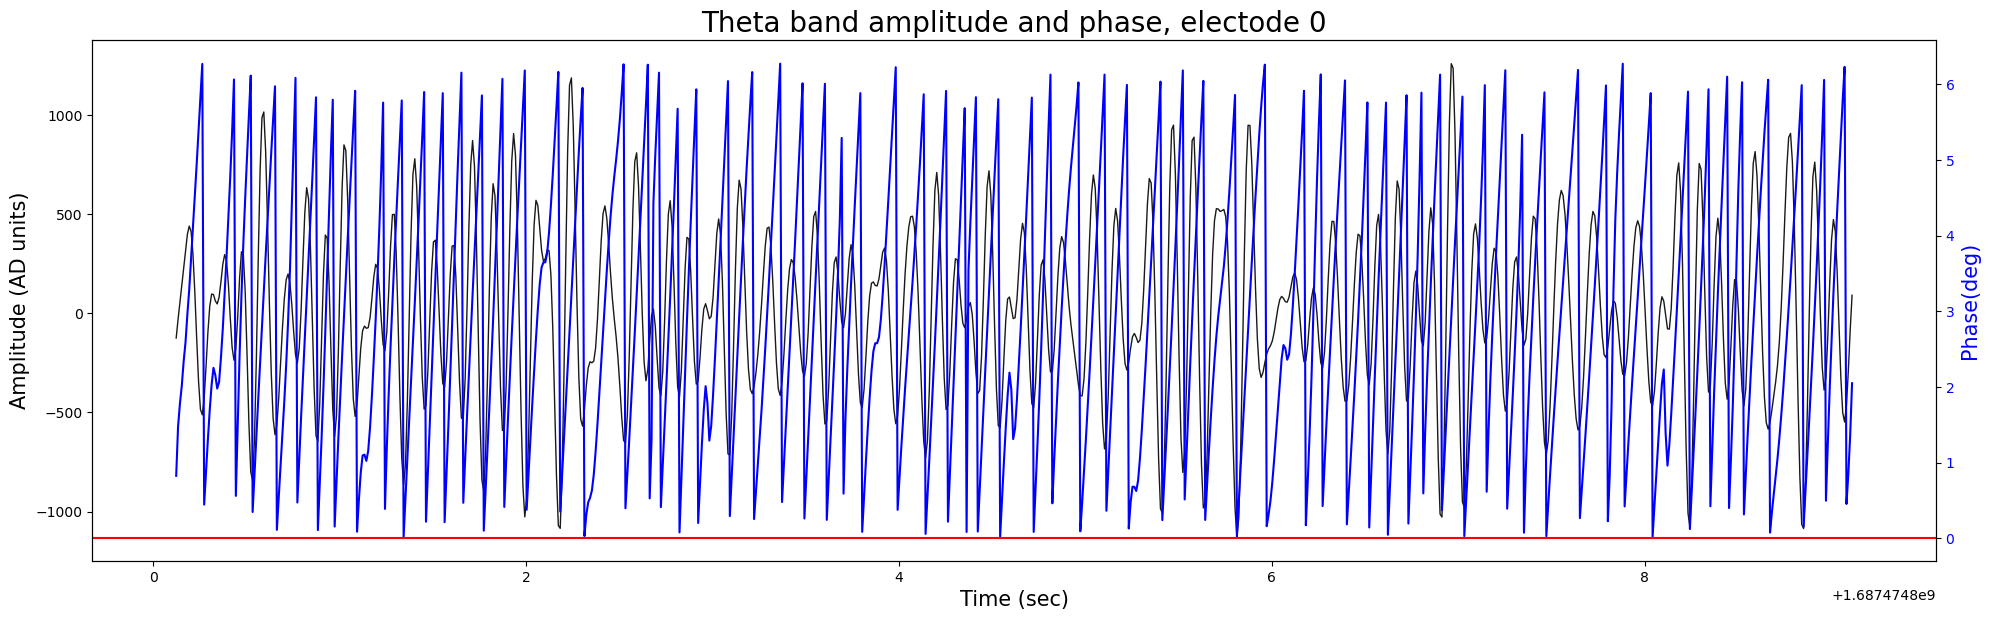

In [13]:
electrode_id = electrode_list[0]  # the electrode for which we want to plot
plot_start, plot_end = 0, 5000  # start/end time of plotting

fig, ax1 = plt.subplots(figsize=(20, 6))
ax1.set_xlabel("Time (sec)", fontsize=15)
ax1.set_ylabel("Amplitude (AD units)", fontsize=15)
ax1.plot(
    theta_phase.index[plot_start:plot_end],
    theta_band_selected[
        plot_start:plot_end, np.where(np.array(electrode_list) == 0)[0][0]
    ],
    "k-",
    linewidth=1,
    alpha=0.9,
)
ax1.tick_params(axis="y", labelcolor="k")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel("Phase(deg)", color="b", fontsize=15)
ax2.plot(
    theta_phase.index[plot_start:plot_end],
    theta_phase[f"electrode {electrode_id}"].iloc[plot_start:plot_end],
    "b",
)
ax2.tick_params(axis="y", labelcolor="b")
ax2.axhline(y=0, color="r", linestyle="-")

fig.tight_layout()
ax1.set_title(
    f"Theta band amplitude and phase, electrode {electrode_id}",
    fontsize=20,
)

We can also plot the theta power.

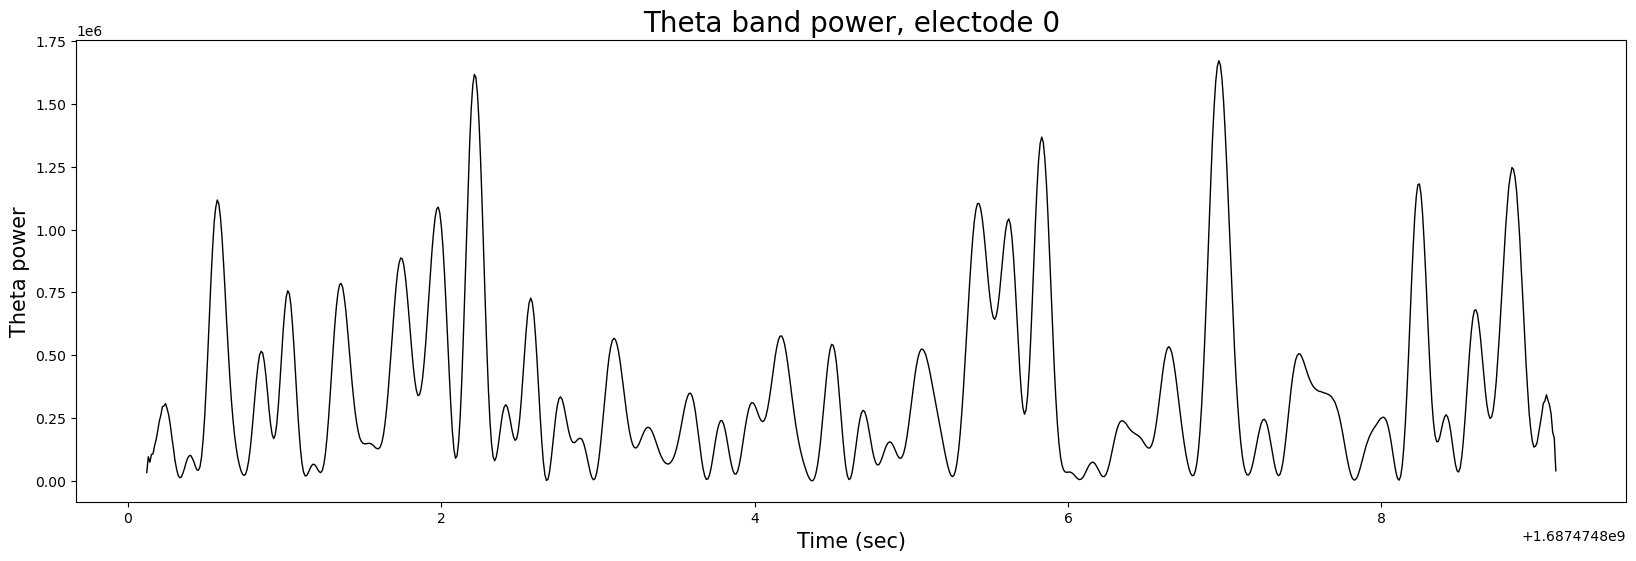

In [14]:
electrode_id = electrode_list[0]  # the electrode for which we want to plot
plot_start, plot_end = 0, 5000  # start/end time of plotting

fig, ax = plt.subplots(figsize=(20, 6))
ax.set_xlabel("Time (sec)", fontsize=15)
ax.set_ylabel("Theta power", fontsize=15)
ax.plot(
    theta_power.index[plot_start:plot_end],
    theta_power[f"electrode {electrode_id}"].iloc[plot_start:plot_end],
    "k-",
    linewidth=1,
)
ax.tick_params(axis="y", labelcolor="k")
ax.set_title(
    f"Theta band power, electrode {electrode_id}",
    fontsize=20,
)

## Up Next

Next, we'll turn our attention to [position data](./20_Position_Trodes.ipynb).